#  T-S Plot Verification


Created by Tore Hattermann

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [2]:
# ## folder where the isomip-plus github repo is located
# baserepo = 'C:/thinf/github/isomip-plus/'
# ## folder where you downloaded the zipped Google Drive data
# basedrive = 'C:\Dropbox\Osci\ISOMIP\common_analysis\ISOMIP+Data 2/'

## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)


In [3]:
#12 model colours for 12 models, generated using https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

# Gade Line assessment
When ice melts into seawater, the resulting water mass will cool and freshen at a constant ratio, causing water mass transformation along characteristic lines in temperature–salinity (T–S) space (Gade 1979). Neglecting corrections due to heat conduction at the ice–ocean interface (Asay-Davis et al. 2016), the slope of these lines is given as $\partial T / \partial S = L/(S_0c_w)$, with specific heat capacity of seawater $c_w = 3974 $ J kg−1K−1 and latent heat of fusion $L = 3.34 \times 10^5$ J kg−1 and salinity $S_0$ of the seawater that is being in contact with the ice, hera taken constant as $S_{ref} = 34.2$ from Asay-Davis 2016 for simplicity, but with insignificant impact on the results.

In absence of other freshwater sources or T–S end-members, Gade-line theory can be used to validate the water mass evolution of the ISOMIP+ ocean models, where water mass properties should be confined within the 

In [4]:
# Definitions
# Gade line
s0 = 34.2 # Sref from Aasay-Davis et al. 2016
sg = np.array([33, 34.75])
tg = np.array([-3, -3+3.34*10**5/(s0*3974)*(sg[1]-sg[0])])

# freezing point linearizaion, Tf = gamma_1 * S + gamma_2 + gamma_3 * P
lambda_1=-0.0573
lambda_2=0.0832
lambda_3=-7.53*10**-4
def tf(s0,p):
    return lambda_1*s0 + lambda_2 + lambda_3*p


In [5]:
sg+0.06,tg

(array([33.06, 34.81]), array([-3.        ,  1.30061482]))

In [96]:
def Gade(T):
    # find form y=mx+b of Gade line given temp
    S_gade = (0.06+sg[0])+(sg[1]-sg[0])/(tg[1]-tg[0])* (T-tg[0])
    return S_gade
def WARM_IC(T):
    # find form y=mx+b of Gade line given temp
    S_IC = 33.8+(34.7-33.8)/(1--1.9)* (T--1.9)
    return S_IC
def WARM_ICT(S):
    # find form y=mx+b of Gade line given temp
    T_IC = -1.9 + (1--1.9)/(34.7-33.8) * (S-33.8)
    return T_IC


Text(0.5, 1.0, 'MITgcm JPL')

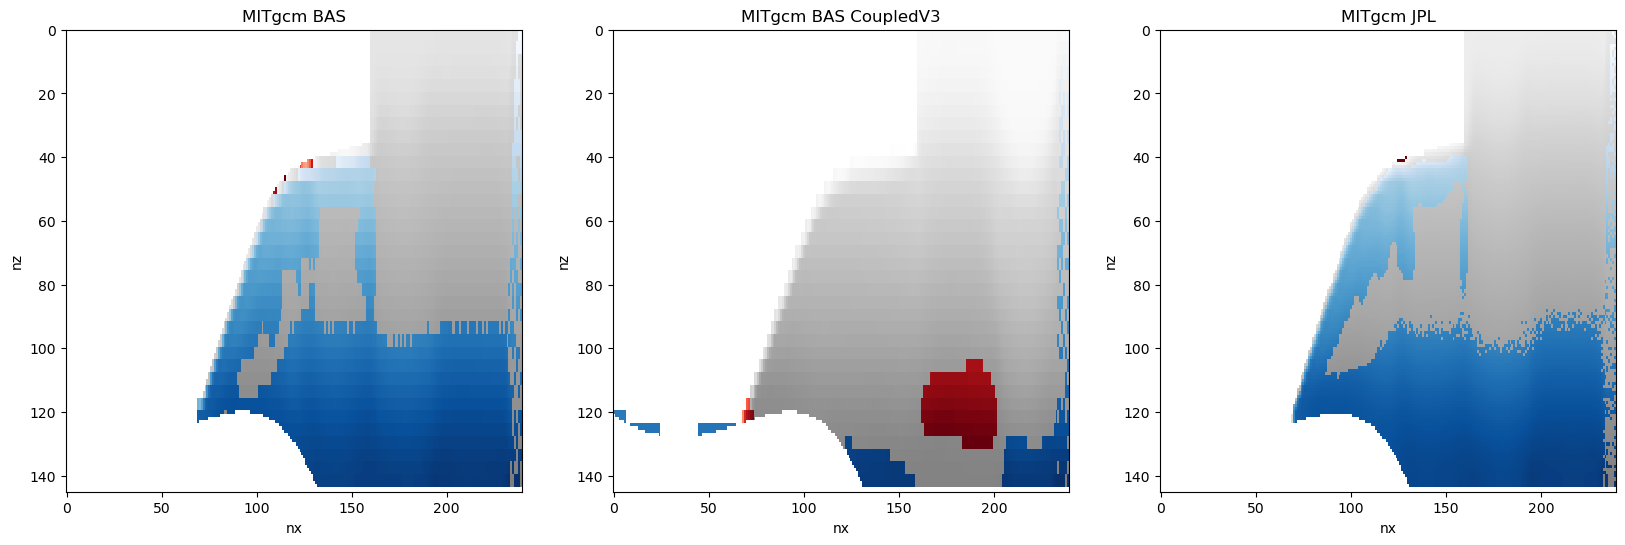

In [49]:
expt = Ocean1_COM

labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

fig = plt.figure(figsize = (20,6))

i = 2 #MITgcm BAS
plt.subplot(1,3,1)

ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
# make x and y coordinates
ds = ds.set_coords(['x', 'y', 'time', 'z'])
nTime = ds.sizes['nTime']
T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
# T_XZ < 1e36 is to get rid of fill values.
T1 = T1.where(T1 < 1e10)
S1 = S1.where(S1 < 1e10)

# plot where fresher than Gade and saltier than Warm IC
S1.plot(alpha = 0.5,cmap = 'Grays',add_colorbar = False)
S1.where(S1<Gade(T1)).plot(cmap = 'Reds',add_colorbar = False,vmin = np.min(S1)-0.1)
S1.where(S1>WARM_IC(T1)).plot(cmap = 'Blues',add_colorbar = False)
plt.ylim(145,0)
plt.title(labels[i])

i = 3 #MITgcm-BAS-Coupled
plt.subplot(1,3,2)

ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
# make x and y coordinates
ds = ds.set_coords(['x', 'y', 'time', 'z'])
nTime = ds.sizes['nTime']
T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
# T_XZ < 1e36 is to get rid of fill values.
T1 = T1.where(T1 < 1e10)
S1 = S1.where(S1 < 1e10)

# plot where fresher than Gade and saltier than Warm IC
S1.plot(alpha = 0.5,cmap = 'Grays',add_colorbar = False)
S1.where(S1<Gade(T1)).plot(cmap = 'Reds',add_colorbar = False,vmin = np.min(S1)-0.1)
S1.where(S1>WARM_IC(T1)).plot(cmap = 'Blues',add_colorbar = False)
plt.ylim(145,0)
plt.title(labels[i])

i = 4 #MITgcm-JPL
plt.subplot(1,3,3)

ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
# make x and y coordinates
ds = ds.set_coords(['x', 'y', 'time', 'z'])
nTime = ds.sizes['nTime']
T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
# T_XZ < 1e36 is to get rid of fill values.
T1 = T1.where(T1 < 1e10)
S1 = S1.where(S1 < 1e10)

# plot where fresher than Gade and saltier than Warm IC
S1.plot(alpha = 0.5,cmap = 'Grays',add_colorbar = False)
S1.where(S1<Gade(T1)).plot(cmap = 'Reds',add_colorbar = False, vmax = np.min(S1),vmin = np.min(S1)-0.1)
S1.where(S1>WARM_IC(T1)).plot(cmap = 'Blues',add_colorbar = False)
plt.ylim(145,0)
plt.title(labels[i])


Text(0.5, 1.0, 'MITgcm JPL')

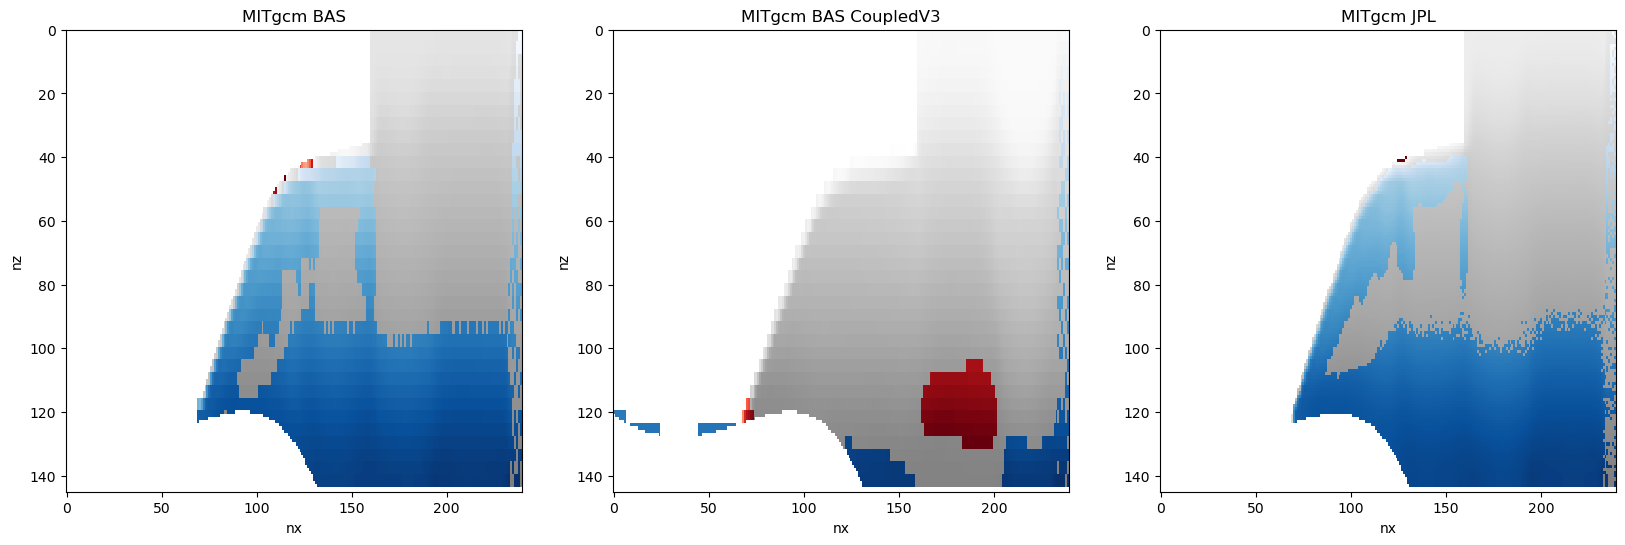

In [49]:
expt = Ocean1_COM

labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

fig = plt.figure(figsize = (20,6))

i = 2 #MITgcm BAS
plt.subplot(1,3,1)

ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
# make x and y coordinates
ds = ds.set_coords(['x', 'y', 'time', 'z'])
nTime = ds.sizes['nTime']
T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
# T_XZ < 1e36 is to get rid of fill values.
T1 = T1.where(T1 < 1e10)
S1 = S1.where(S1 < 1e10)

# plot where fresher than Gade and saltier than Warm IC
S1.plot(alpha = 0.5,cmap = 'Grays',add_colorbar = False)
S1.where(S1<Gade(T1)).plot(cmap = 'Reds',add_colorbar = False,vmin = np.min(S1)-0.1)
S1.where(S1>WARM_IC(T1)).plot(cmap = 'Blues',add_colorbar = False)
plt.ylim(145,0)
plt.title(labels[i])

i = 3 #MITgcm-BAS-Coupled
plt.subplot(1,3,2)

ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
# make x and y coordinates
ds = ds.set_coords(['x', 'y', 'time', 'z'])
nTime = ds.sizes['nTime']
T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
# T_XZ < 1e36 is to get rid of fill values.
T1 = T1.where(T1 < 1e10)
S1 = S1.where(S1 < 1e10)

# plot where fresher than Gade and saltier than Warm IC
S1.plot(alpha = 0.5,cmap = 'Grays',add_colorbar = False)
S1.where(S1<Gade(T1)).plot(cmap = 'Reds',add_colorbar = False,vmin = np.min(S1)-0.1)
S1.where(S1>WARM_IC(T1)).plot(cmap = 'Blues',add_colorbar = False)
plt.ylim(145,0)
plt.title(labels[i])

i = 4 #MITgcm-JPL
plt.subplot(1,3,3)

ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
# make x and y coordinates
ds = ds.set_coords(['x', 'y', 'time', 'z'])
nTime = ds.sizes['nTime']
T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
# T_XZ < 1e36 is to get rid of fill values.
T1 = T1.where(T1 < 1e10)
S1 = S1.where(S1 < 1e10)

# plot where fresher than Gade and saltier than Warm IC
S1.plot(alpha = 0.5,cmap = 'Grays',add_colorbar = False)
S1.where(S1<Gade(T1)).plot(cmap = 'Reds',add_colorbar = False, vmax = np.min(S1),vmin = np.min(S1)-0.1)
S1.where(S1>WARM_IC(T1)).plot(cmap = 'Blues',add_colorbar = False)
plt.ylim(145,0)
plt.title(labels[i])


2
3
4
5
10


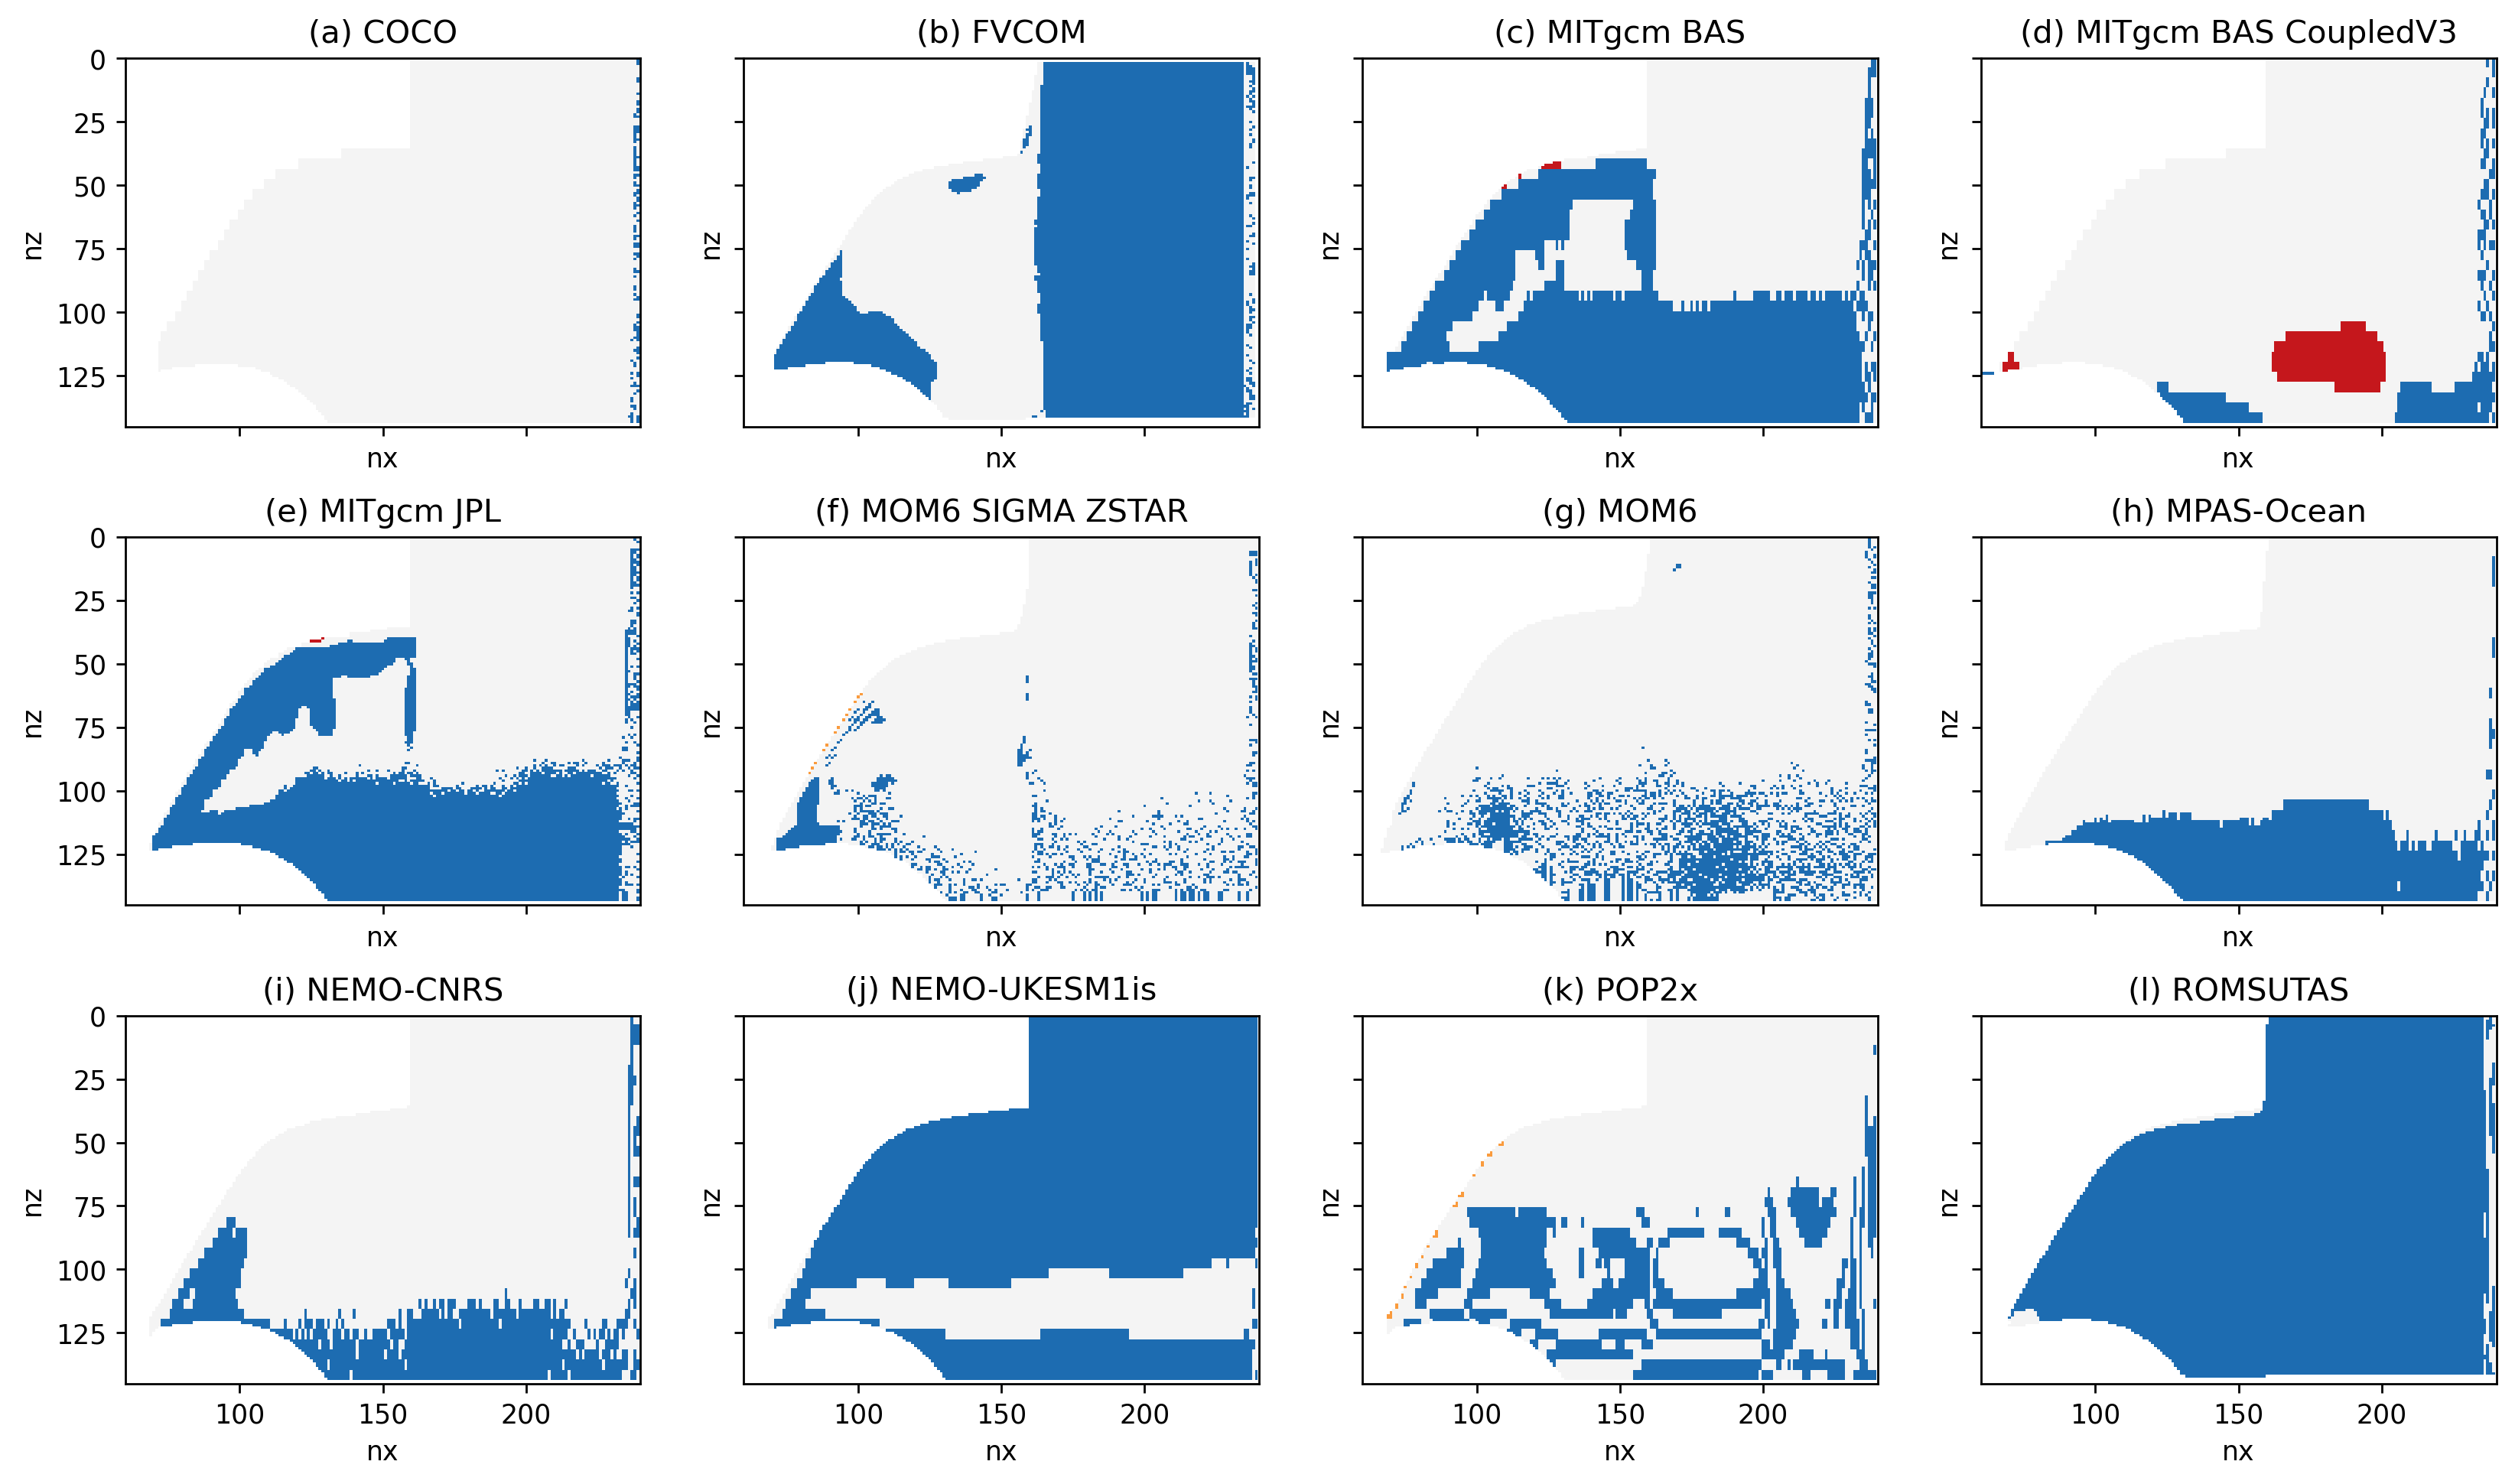

In [92]:
expt = Ocean1_COM

labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
lenth = len(labels)
fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 250)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    
    # plot where fresher than Gade and saltier than Warm IC
    (S1*0+1).plot(ax = ax, alpha = 0.1,cmap = 'Grays',add_colorbar = False)
    if np.min(S1-Gade(T1))<0:
        print(i)
        (S1*0+1).where(S1<Gade(T1)).plot(ax = ax, cmap = 'Reds',add_colorbar = False, vmax = 1.3,vmin = 0)
    (S1*0+1).where(S1>WARM_IC(T1)).plot(ax = ax, cmap = 'Blues',add_colorbar = False, vmax = 1.3,vmin = 0)
    if np.min(T1-tf(s0,720))<0:
        print(i)
        (T1.where(T1<tf(s0,720))*0+1).plot(ax = ax, cmap = 'plasma',add_colorbar = False, vmax = 1.3,vmin = 0)
        
    ax.set_ylim(145,0)
    ax.set_xlim(60,240)
    ax.set_title('('+alphabet[i]+') '+labels[i])
    
fig.subplots_adjust(wspace = 0.2,hspace = 0.3)

2
3
4
5
10


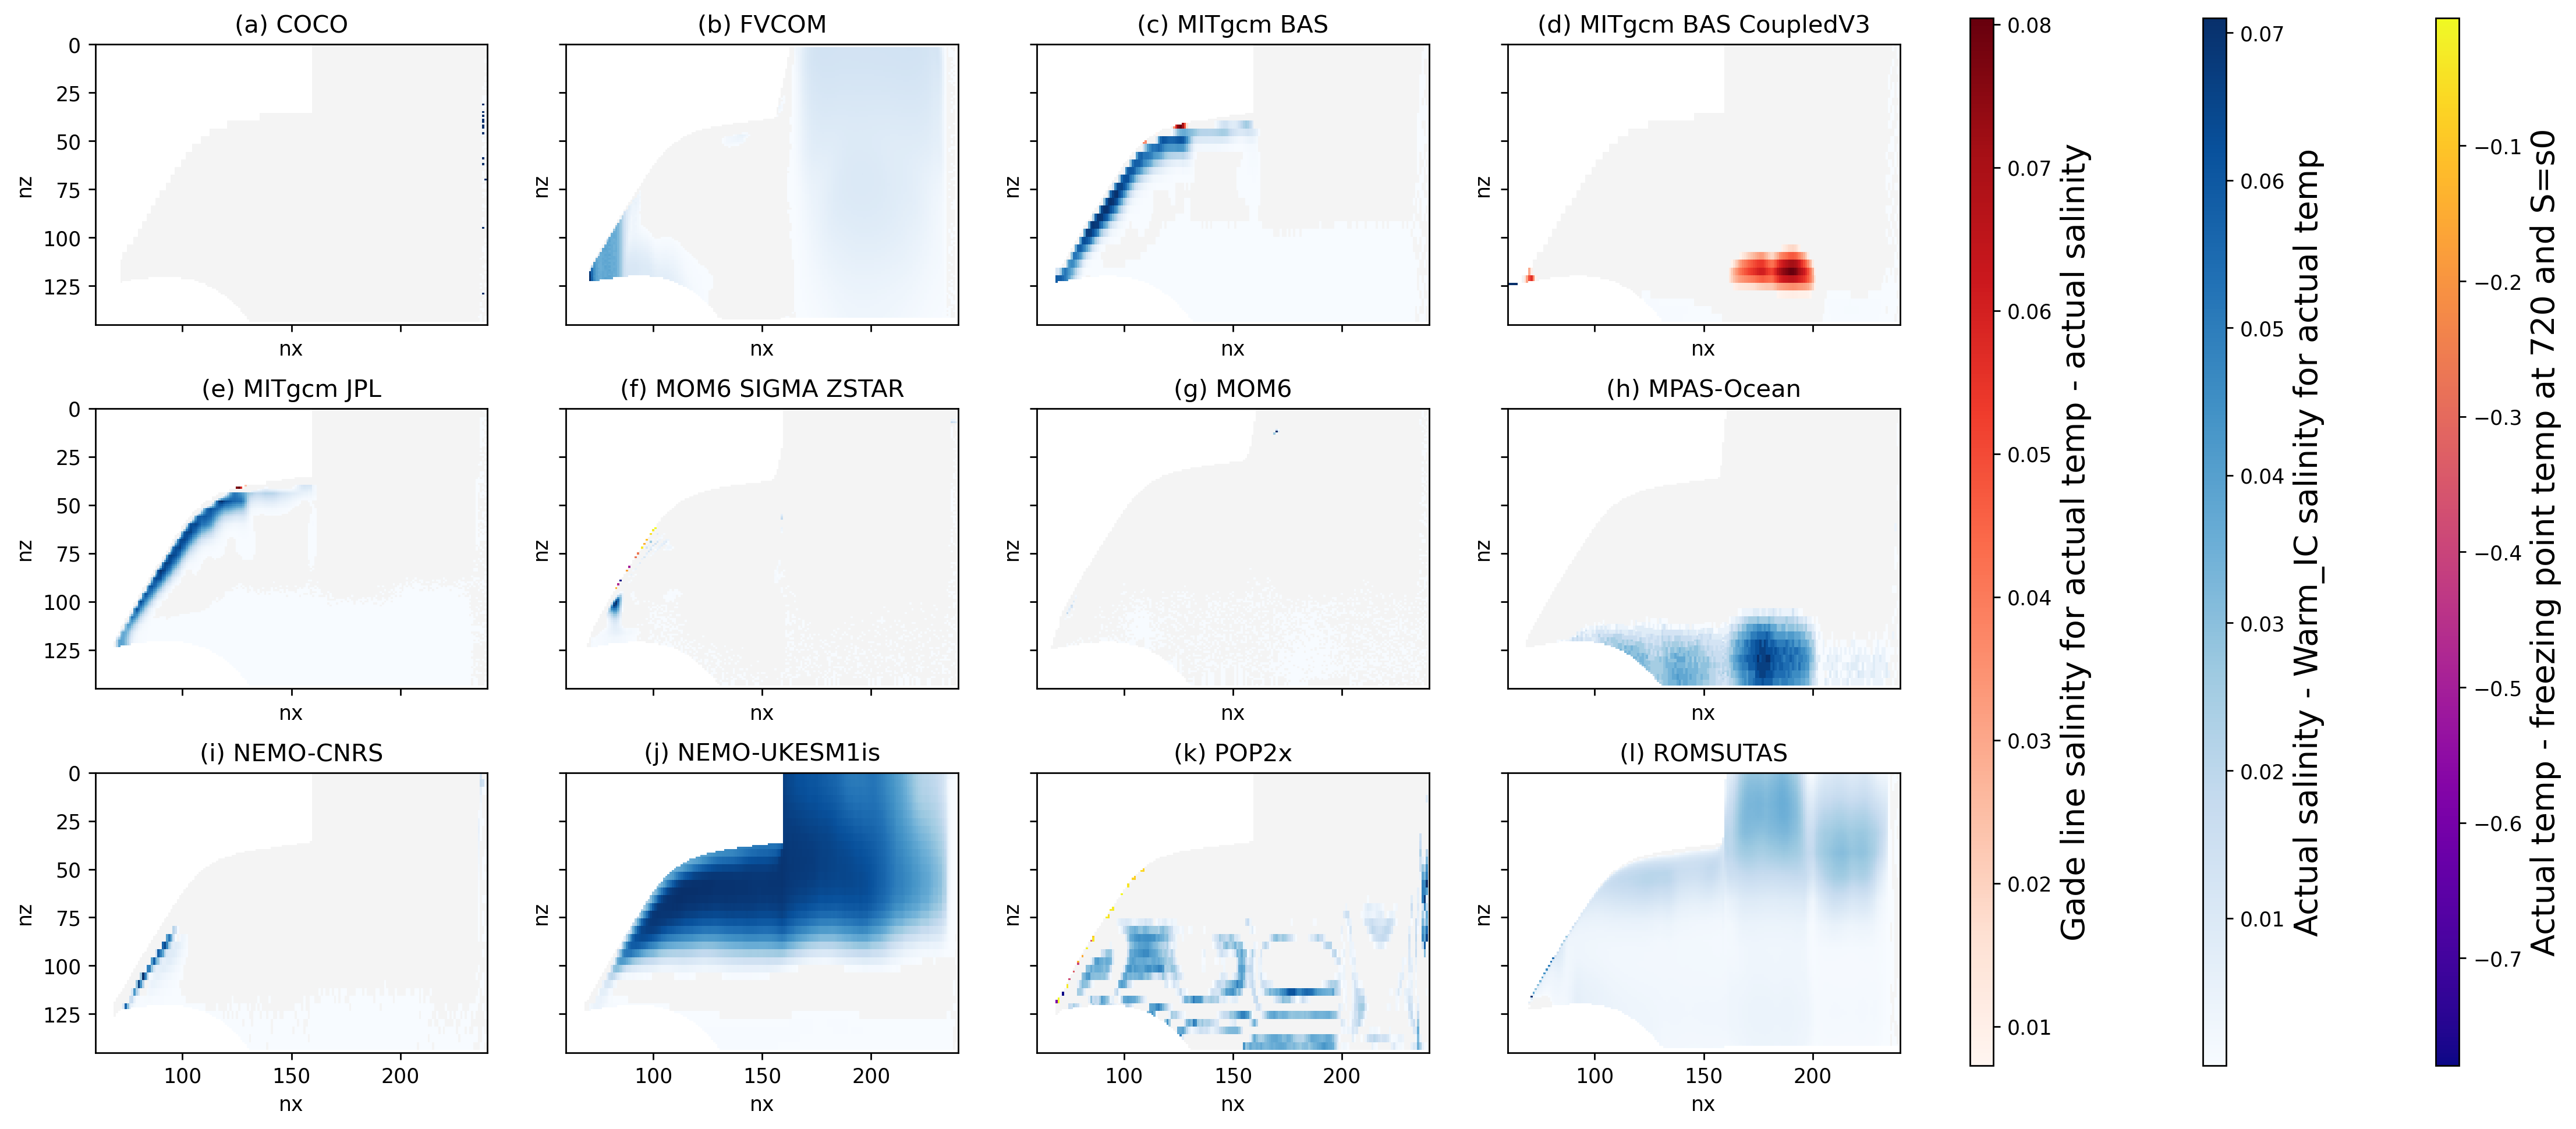

In [95]:
expt = Ocean1_COM

labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
lenth = len(labels)
fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 250)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    
    # plot where fresher than Gade and saltier than Warm IC
    (S1*0+1).plot(ax = ax, alpha = 0.1,cmap = 'Grays',add_colorbar = False)
    if np.min(S1-Gade(T1))<0:
        print(i)
        c = (Gade(T1)-S1).where(S1<Gade(T1)).plot(ax = ax, cmap = 'Reds',add_colorbar = False)
    d = (S1-WARM_IC(T1)).where(S1>WARM_IC(T1)).plot(ax = ax, cmap = 'Blues',add_colorbar = False)
    if np.min(T1-tf(s0,720))<0:
        print(i)
        e = ((T1-tf(s0,720)).where(T1<tf(s0,720))).plot(ax = ax, cmap = 'plasma',add_colorbar = False)
        
    ax.set_ylim(145,0)
    ax.set_xlim(60,240)
    ax.set_title('('+alphabet[i]+') '+labels[i])

cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel('Gade line salinity for actual temp - actual salinity', fontsize = 16)

cax = plt.axes([1.03,0.1,0.01,0.8])
cbar = plt.colorbar(d, cax = cax)
cbar.ax.set_ylabel('Actual salinity - Warm_IC salinity for actual temp', fontsize = 16)

cax = plt.axes([1.13,0.1,0.01,0.8])
cbar = plt.colorbar(e, cax = cax)
cbar.ax.set_ylabel('Actual temp - freezing point temp at 720 and S=s0', fontsize = 16)

fig.subplots_adjust(wspace = 0.2,hspace = 0.3)

2
3
4
5
10


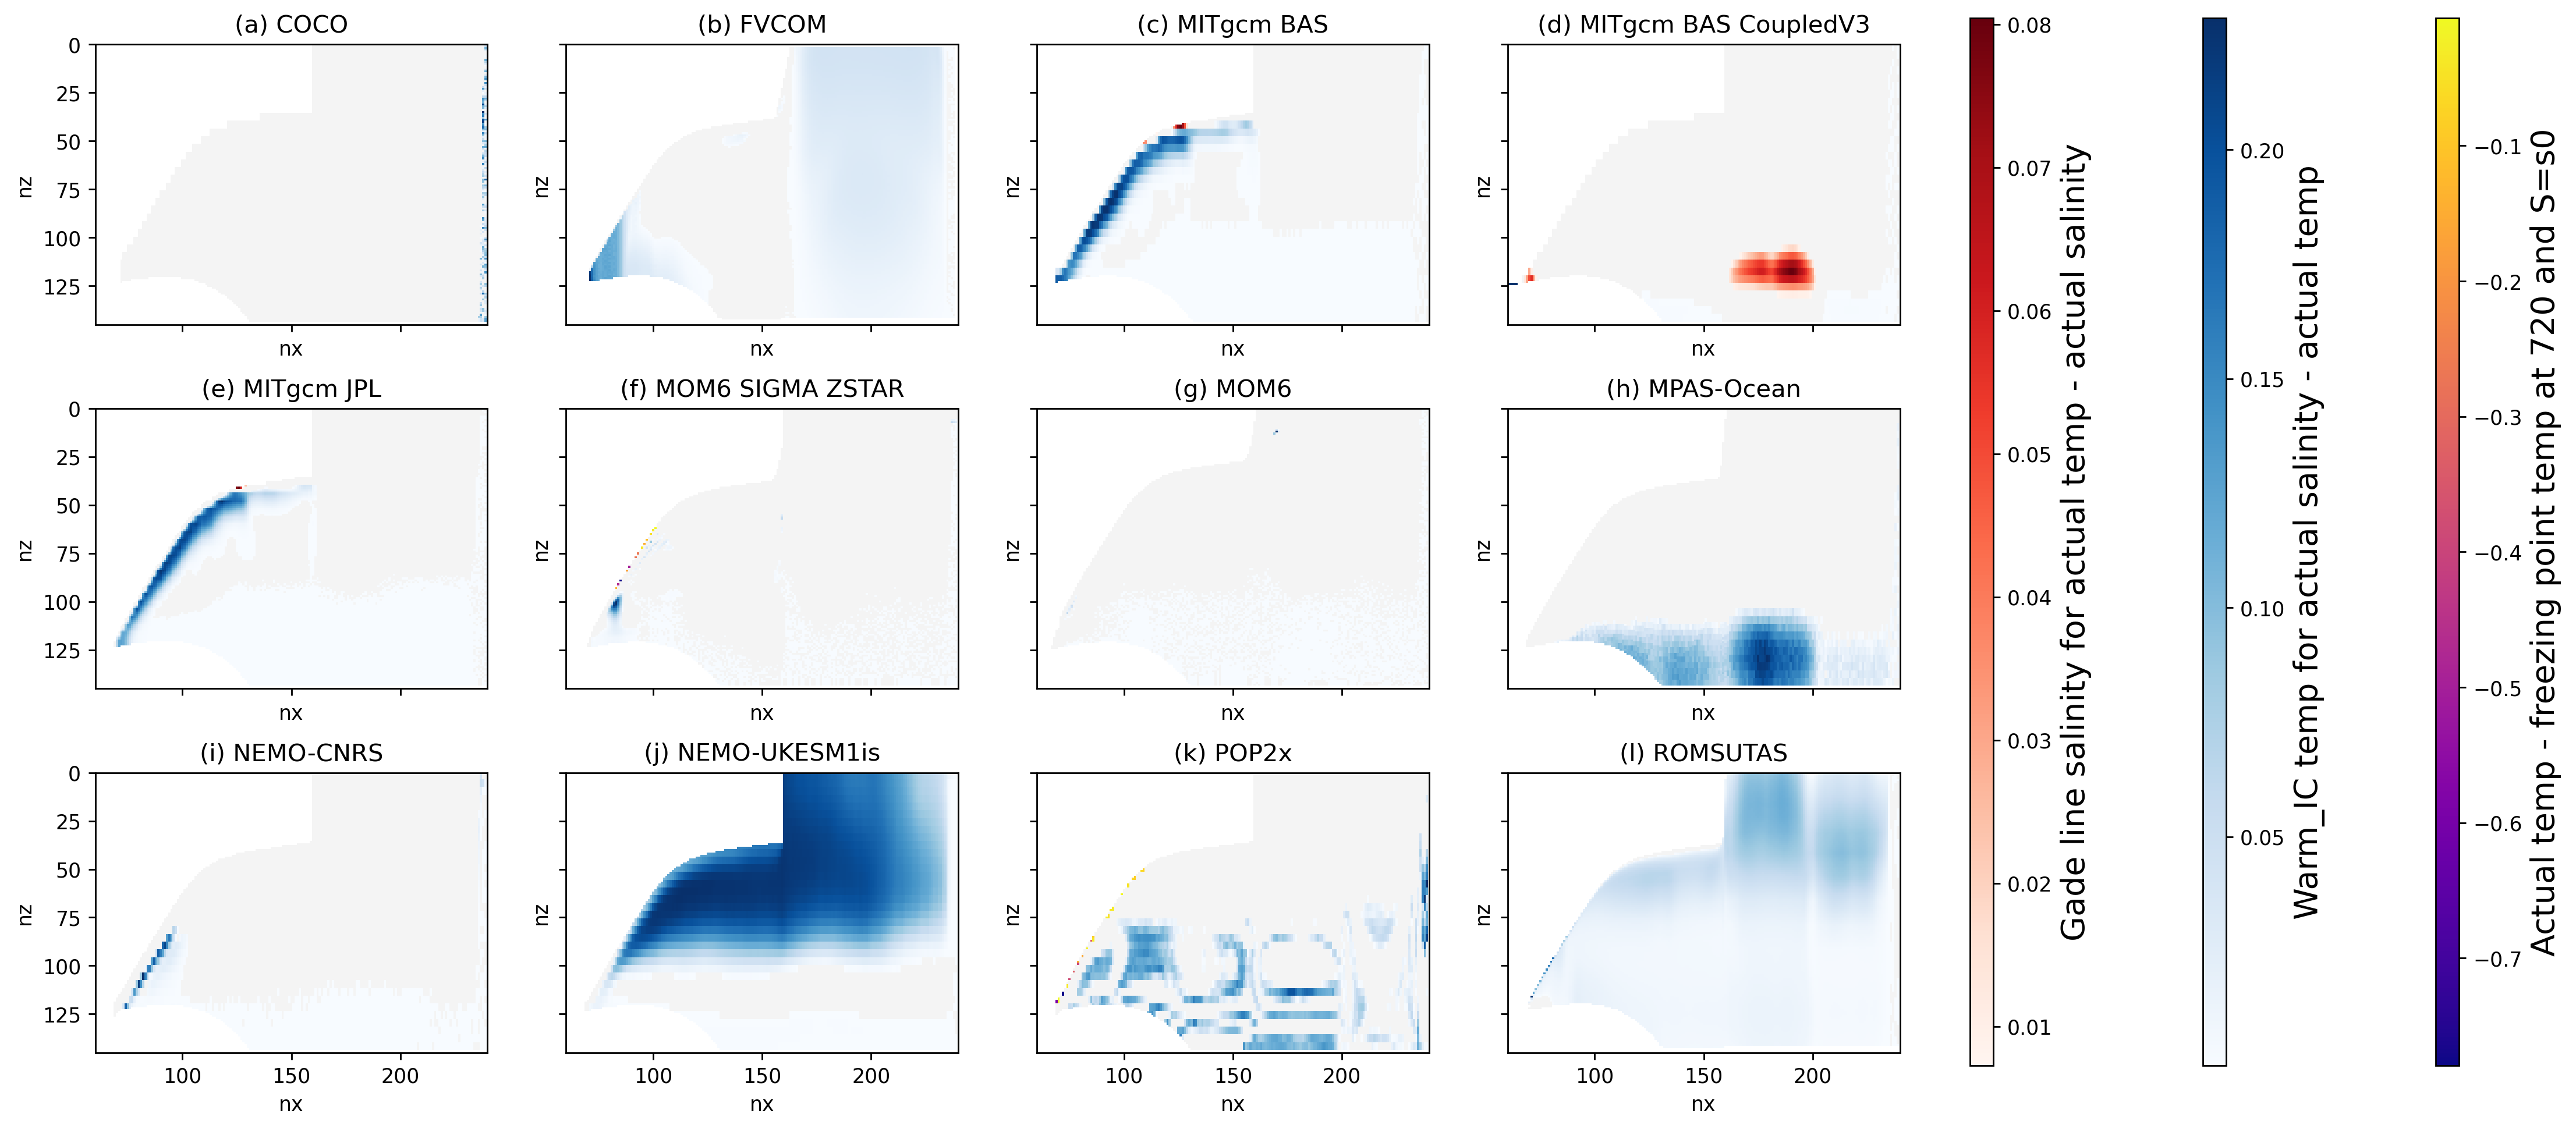

In [99]:
expt = Ocean1_COM

labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
lenth = len(labels)
fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 250)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    
    # plot where fresher than Gade and saltier than Warm IC
    (S1*0+1).plot(ax = ax, alpha = 0.1,cmap = 'Grays',add_colorbar = False)
    if np.min(S1-Gade(T1))<0:
        print(i)
        c = (Gade(T1)-S1).where(S1<Gade(T1)).plot(ax = ax, cmap = 'Reds',add_colorbar = False)
    d = (WARM_ICT(S1)-T1).where(T1<WARM_ICT(S1)).plot(ax = ax, cmap = 'Blues',add_colorbar = False)
    if np.min(T1-tf(s0,720))<0:
        print(i)
        e = ((T1-tf(s0,720)).where(T1<tf(s0,720))).plot(ax = ax, cmap = 'plasma',add_colorbar = False)
        
    ax.set_ylim(145,0)
    ax.set_xlim(60,240)
    ax.set_title('('+alphabet[i]+') '+labels[i])

cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel('Gade line salinity for actual temp - actual salinity', fontsize = 16)

cax = plt.axes([1.03,0.1,0.01,0.8])
cbar = plt.colorbar(d, cax = cax)
cbar.ax.set_ylabel('Warm_IC temp for actual salinity - actual temp', fontsize = 16)

cax = plt.axes([1.13,0.1,0.01,0.8])
cbar = plt.colorbar(e, cax = cax)
cbar.ax.set_ylabel('Actual temp - freezing point temp at 720 and S=s0', fontsize = 16)

fig.subplots_adjust(wspace = 0.2,hspace = 0.3)

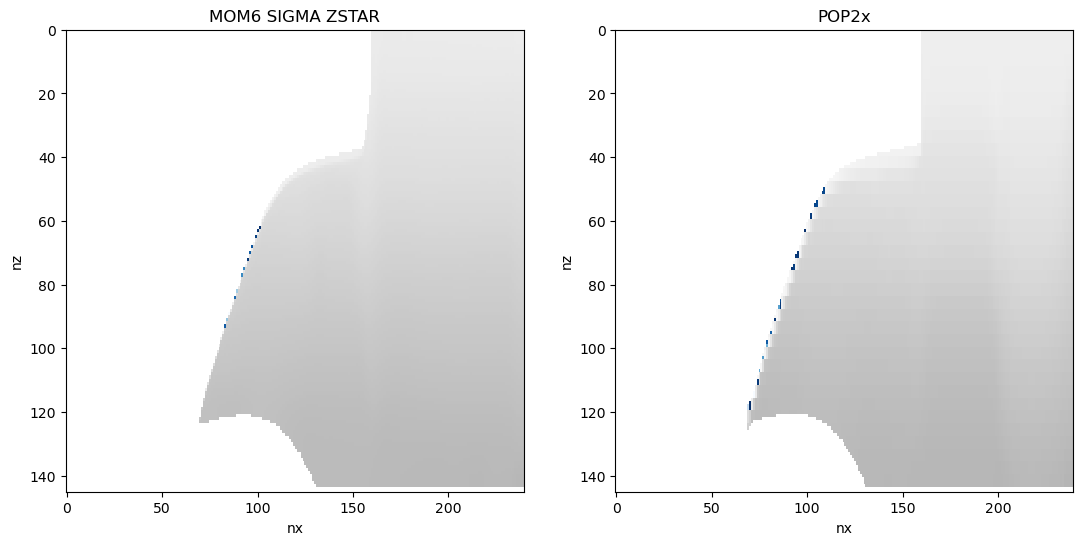

In [52]:
expt = Ocean1_COM

labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)
fig = plt.figure(figsize = (13,6))

plt.subplot(1,2,1)

i = 5 #MOM6-SIGMAZSTAR

ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
# make x and y coordinates
ds = ds.set_coords(['x', 'y', 'time', 'z'])
nTime = ds.sizes['nTime']
T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
# T_XZ < 1e36 is to get rid of fill values.
T1 = T1.where(T1 < 1e10)
S1 = S1.where(S1 < 1e10)

# plot where fresher than Gade and saltier than Warm IC
T1.plot(alpha = 0.5,cmap = 'Grays',add_colorbar = False)
T1.where(T1<tf(s0,720)).plot(cmap = 'Blues',add_colorbar = False)
plt.ylim(145,0)
plt.title(labels[i])

i = 10 # POP2x
plt.subplot(1,2,2)

ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
# make x and y coordinates
ds = ds.set_coords(['x', 'y', 'time', 'z'])
nTime = ds.sizes['nTime']
T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
# T_XZ < 1e36 is to get rid of fill values.
T1 = T1.where(T1 < 1e10)
S1 = S1.where(S1 < 1e10)

# plot where fresher than Gade and saltier than Warm IC
T1.plot(alpha = 0.5,cmap = 'Grays',add_colorbar = False)
T1.where(T1<tf(s0,720)).plot(cmap = 'Blues',add_colorbar = False)
plt.ylim(145,0)
plt.title(labels[i])
plt.show()

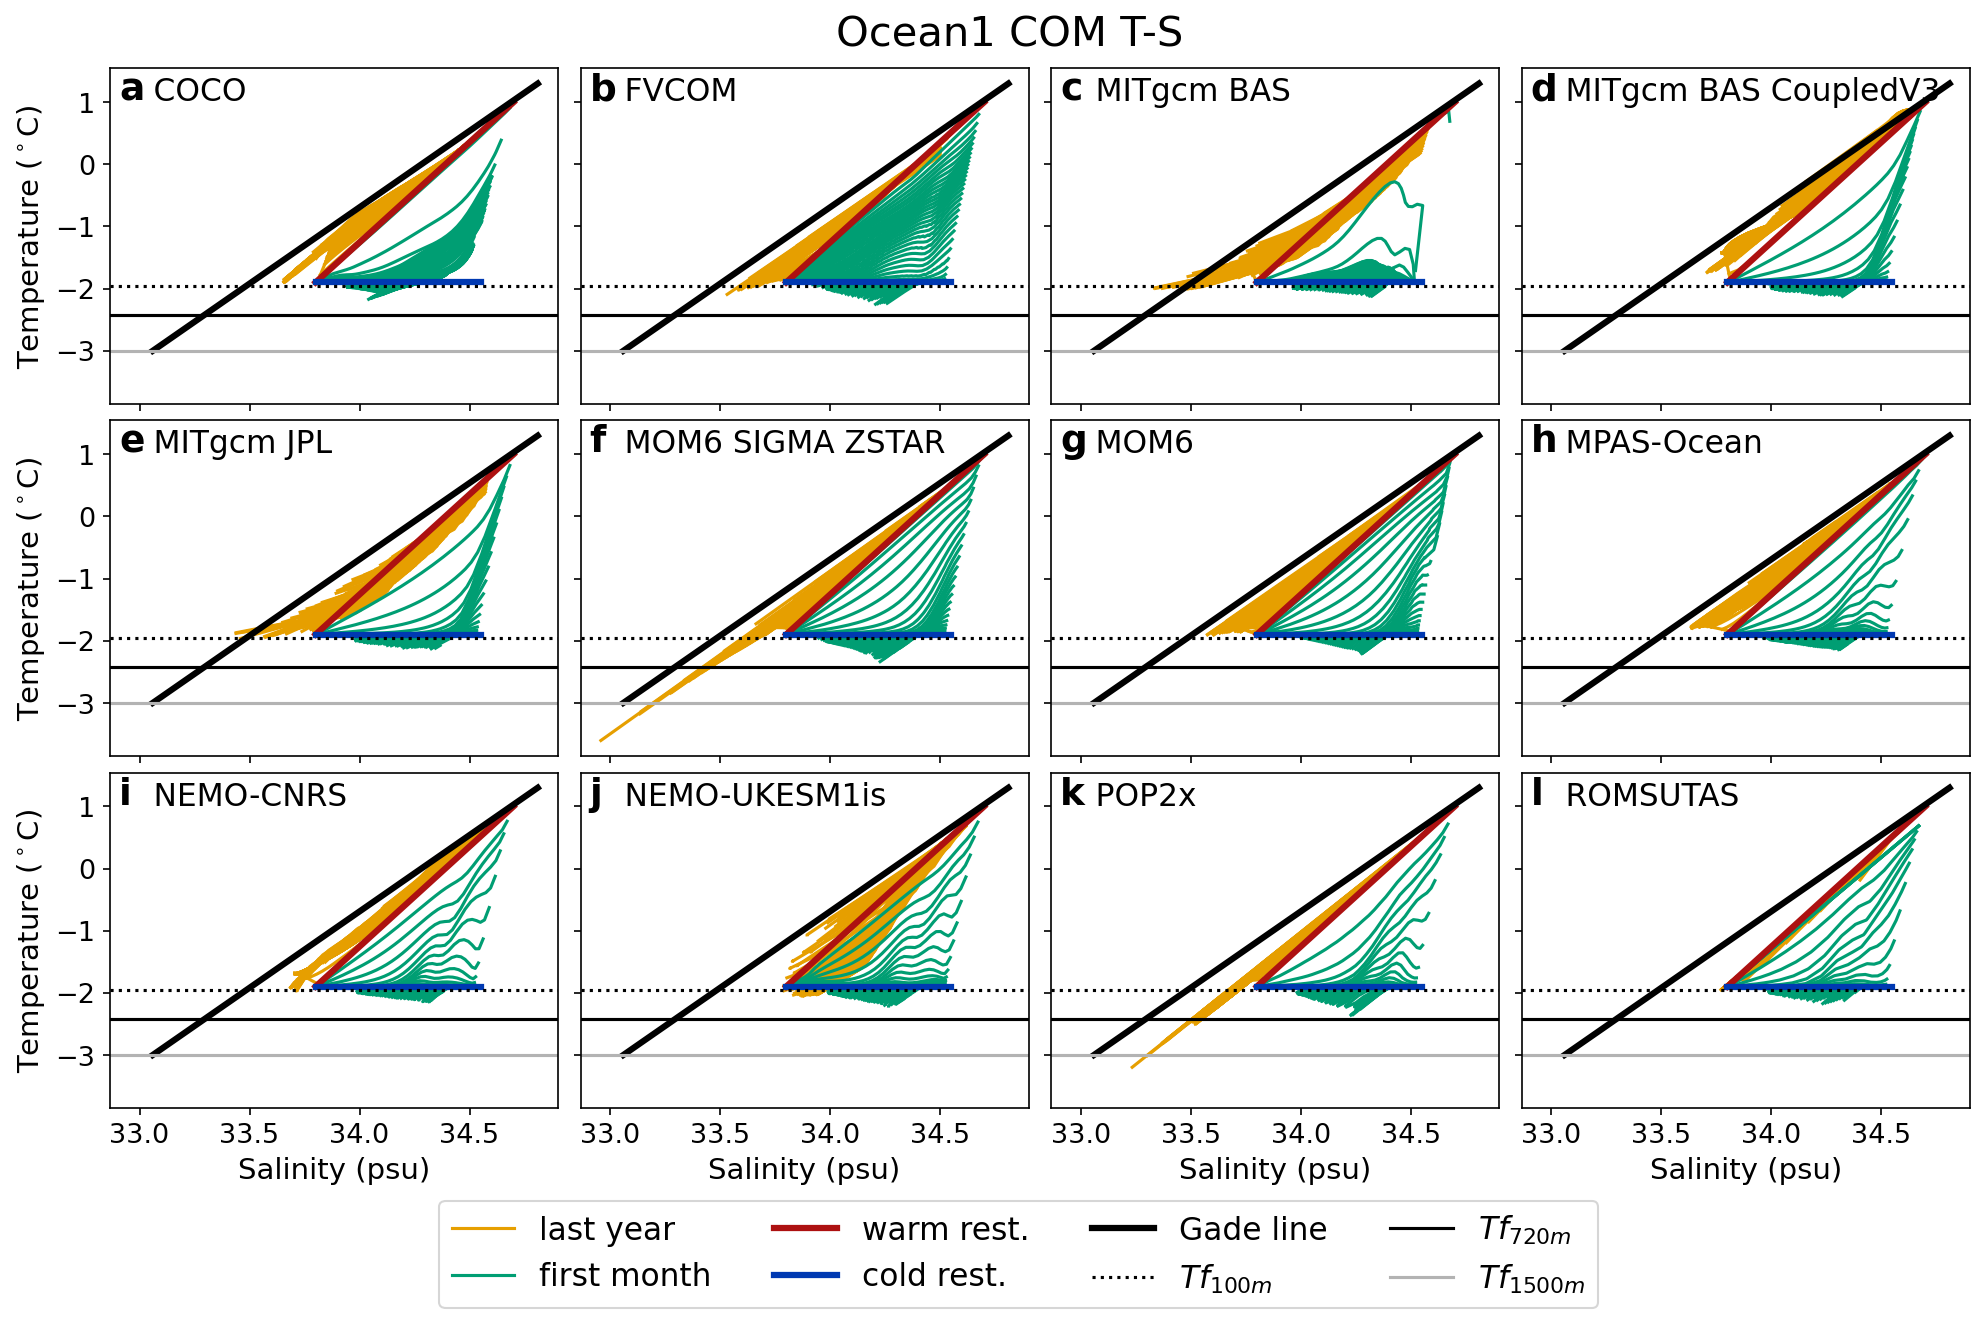

In [57]:
expt = Ocean1_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 150)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 11)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 11)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.plot(
        S1,T1,
        color = '#E69F00')
    ax.plot(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year')
    ax.plot(
        S0,T0,
        color = '#009E73')
    ax.plot(
        S0[0],T0[0],
        color = '#009E73', label = 'first month')
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 3)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 3)
    ax.plot(
        sg+0.06,tg,
        color = '#000000', label = 'Gade line', linewidth = 3)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$')
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-2.45,-0.23), ncol = 4)
axes[0,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[1,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,1].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,2].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,3].set_xlabel('Salinity (psu)', fontsize = 14)

#plt.savefig("gade_line_Ocean1_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('Ocean1 COM T-S', y=0.92,fontsize = 20);
plt.show()

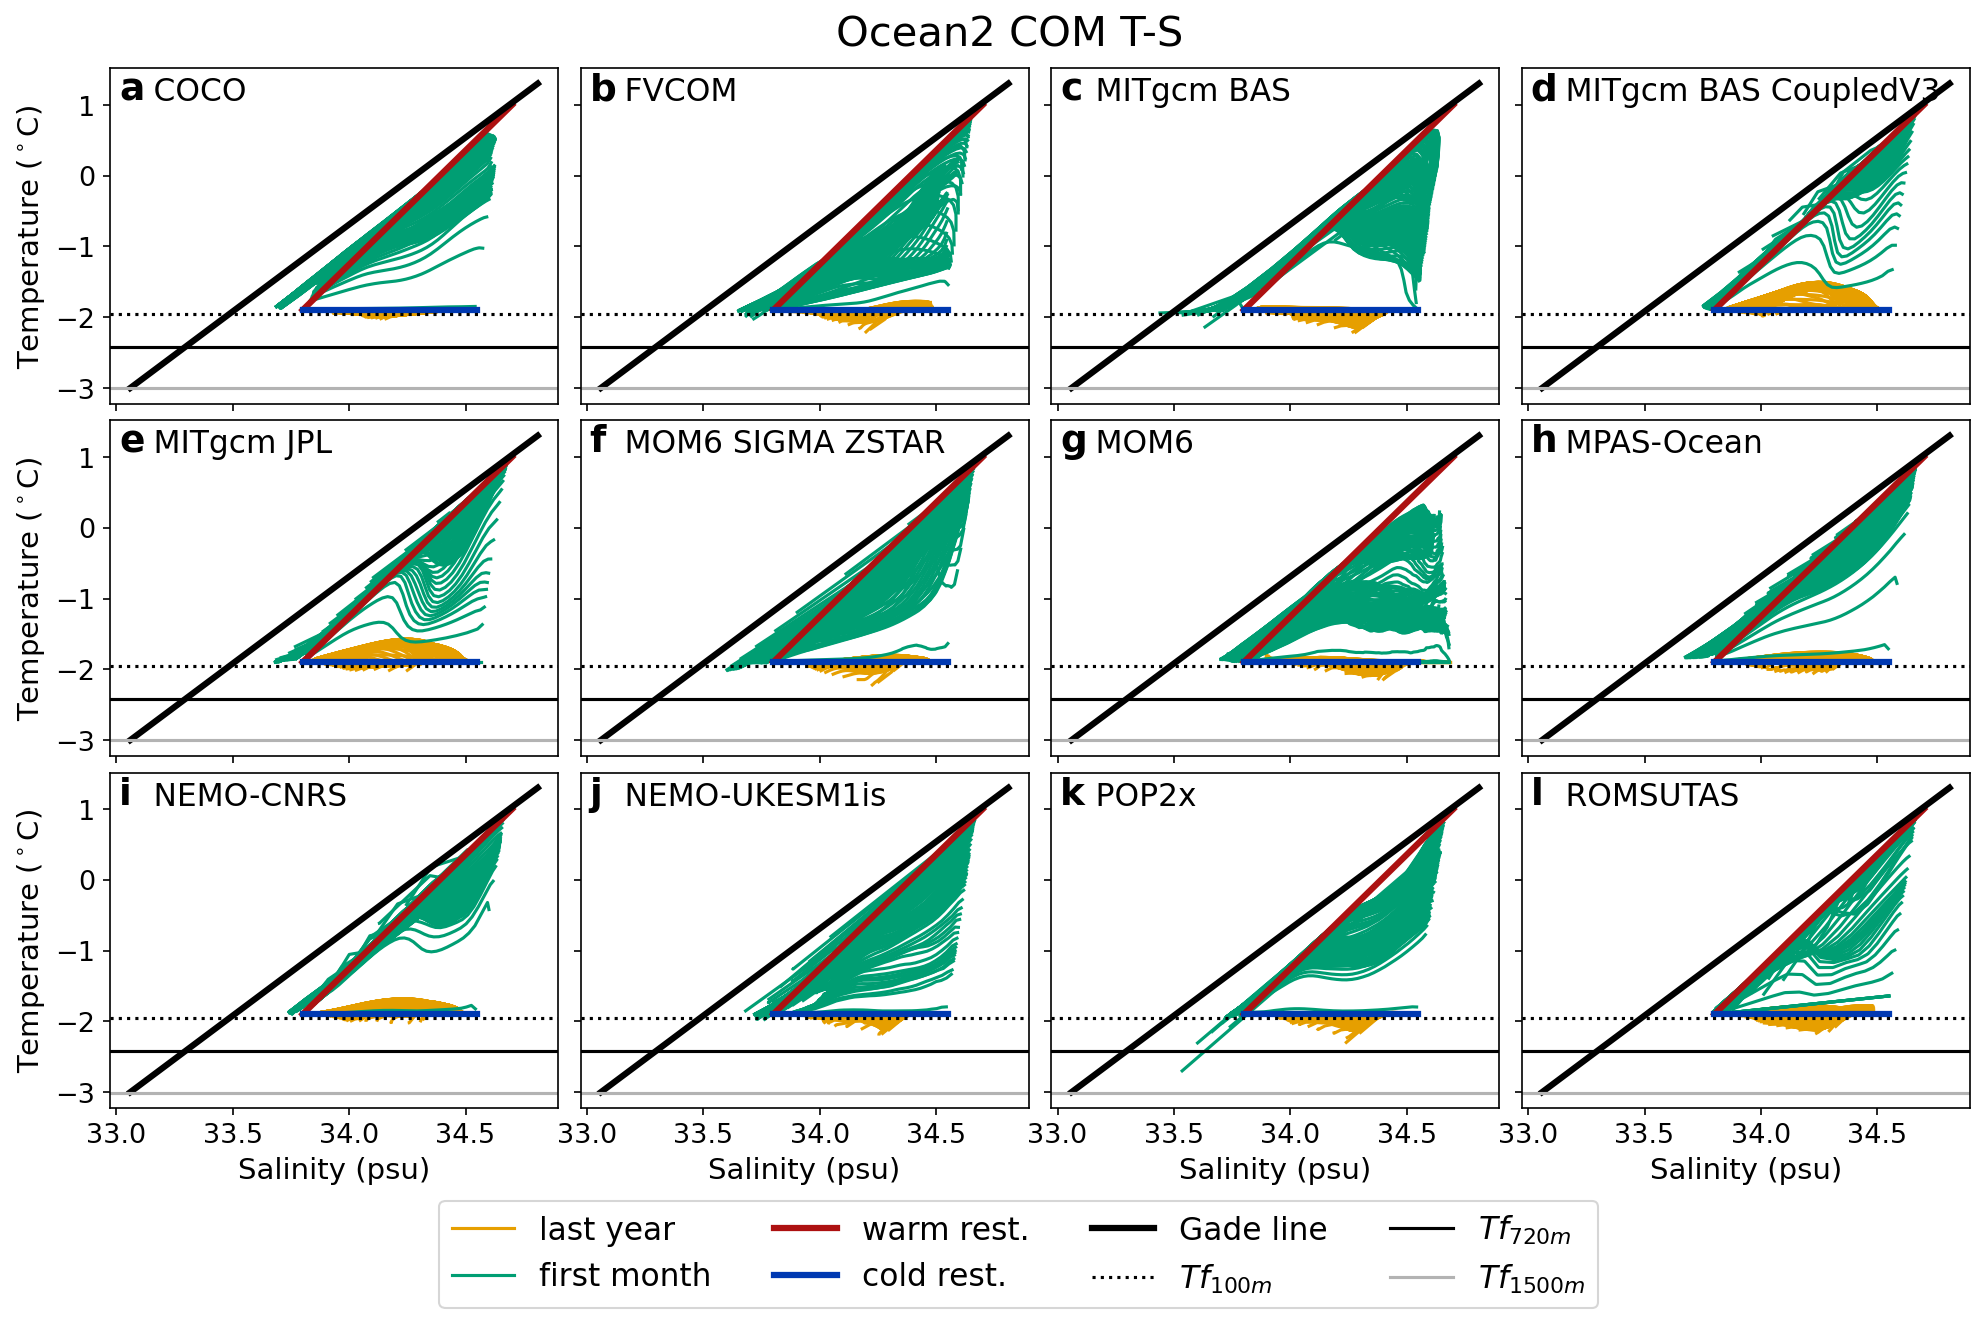

In [11]:
expt = Ocean2_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 150)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 11)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 11)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.plot(
        S1,T1,
        color = '#E69F00')
    ax.plot(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year')
    ax.plot(
        S0,T0,
        color = '#009E73')
    ax.plot(
        S0[0],T0[0],
        color = '#009E73', label = 'first month')
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 3)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 3)
    ax.plot(
        sg+0.06,tg,
        color = '#000000', label = 'Gade line', linewidth = 3)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$')
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-2.45,-0.23), ncol = 4)
axes[0,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[1,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,1].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,2].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,3].set_xlabel('Salinity (psu)', fontsize = 14)

# plt.savefig("gade_line_Ocean2_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('Ocean2 COM T-S', y=0.92,fontsize = 20);
plt.show()

colors from https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230039B2-%23D55E00-%23AD1111